In [21]:
# !pip install torchbnn

In [22]:
# !pip install tensorboard

In [23]:
# !pip install torchvision

In [24]:
import numpy as np
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torchbnn as bnn
from torchbnn.modules.loss import _Loss

import math

from torch.nn import Module, Parameter
import torch.nn.init as init
import torch.nn.functional as F

import pickle

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# Constants
batch_size = 128
num_classes = 10
input_dim = 784

# Hyperparameters
num_samples = 2
lr = 1e-3
log_sigma1 = -3
log_sigma2 = -8
pi = 0.5
hidden_dim = 1200

In [27]:
# iris = datasets.load_iris()
training_data = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
training_set, validation_set = torch.utils.data.random_split(training_data, [50000, 10000])
test_data = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [28]:
num_trainbatches = int(len(training_set) / batch_size) + 1
train_denom = 2 ** num_trainbatches  - 1

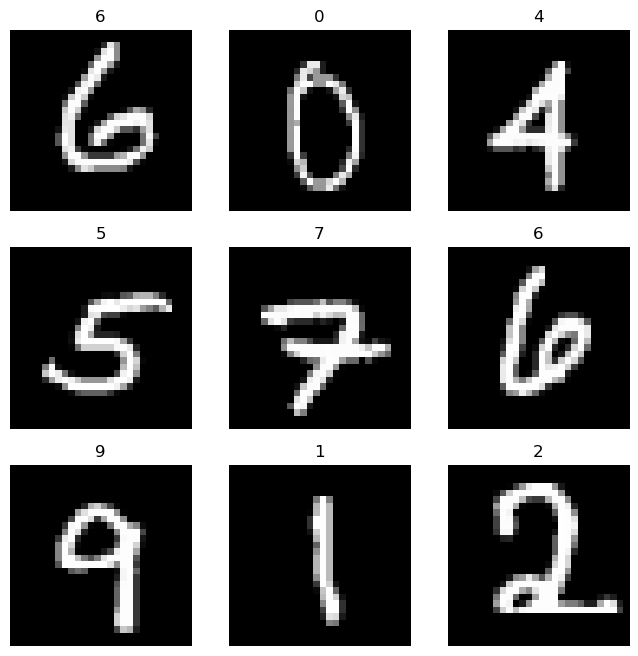

In [29]:
# Visualize the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# No need to normalize. The data values are already between 0 and 1

In [30]:
# print(img.shape)
print(len(training_set),len(validation_set))

50000 10000


In [31]:
class BayesLinearMixture(Module):
    r"""
    Applies Bayesian Linear
    Arguments:
        prior_mu (Float): mean of prior normal distribution.
        prior_sigma (Float): sigma of prior normal distribution.
    .. note:: other arguments are following linear of pytorch 1.2.0.
    https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py
    
    """
    __constants__ = ['prior_mu', 'prior_sigma', 'bias', 'in_features', 'out_features']

    def __init__(self, prior_mu1, prior_sigma1, prior_mu2, prior_sigma2, pi, in_features, out_features):
        super(BayesLinearMixture, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.prior_mu1 = prior_mu1
        self.prior_sigma1 = prior_sigma1
        self.prior_log_sigma1 = math.log(prior_sigma1)

        self.prior_mu2 = prior_mu2
        self.prior_sigma2 = prior_sigma2
        self.prior_log_sigma2 = math.log(prior_sigma2)

        self.pi = pi

        self.weight_mu = Parameter(torch.Tensor(out_features, in_features))
#         self.weight_log_sigma = Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer('weight_eps', None)

#         if bias is None or bias is False :
#             self.bias = False
#         else :
#             self.bias = True

#         if self.bias:
#             self.bias_mu = Parameter(torch.Tensor(out_features))
#             self.bias_log_sigma = Parameter(torch.Tensor(out_features))
#             self.register_buffer('bias_eps', None)
#         else:
#             self.register_parameter('bias_mu', None)
#             self.register_parameter('bias_log_sigma', None)
#             self.register_buffer('bias_eps', None)
            
        self.reset_parameters()

    def reset_parameters(self):
        # Initialization method of Adv-BNN
        stdv = 1. / math.sqrt(self.weight_mu.size(1))
        self.weight_mu.data.uniform_(-stdv, stdv)
        self.weight_rho.data.fill_(self.prior_log_sigma1)
#         if self.bias :
#             self.bias_mu.data.uniform_(-stdv, stdv)
#             self.bias_log_sigma.data.fill_(self.prior_log_sigma1)
  
    def freeze(self) :
        self.weight_eps = torch.randn_like(self.weight_log_sigma)
#         if self.bias :
#             self.bias_eps = torch.randn_like(self.bias_log_sigma)
        
    def unfreeze(self) :
        self.weight_eps = None
#         if self.bias :
#             self.bias_eps = None 
            
    def forward(self, input):
        r"""
        Overriden.
        """
#         if self.weight_eps is None :
        eps = torch.torch.randn_like(self.weight_rho)
        self.weight = self.weight_mu + torch.log1p(torch.exp(self.weight_rho)) * eps
#         else :
#             self.weight = self.weight_mu + torch.exp(self.weight_log_sigma) * self.weight_eps
        
#         if self.bias:
#             if self.bias_eps is None :
#                 bias = self.bias_mu + torch.exp(self.bias_log_sigma) * torch.randn_like(self.bias_log_sigma)
#             else :
#                 bias = self.bias_mu + torch.exp(self.bias_log_sigma) * self.bias_eps                
#         else :
#             bias = None

        return F.linear(input, self.weight, bias=None)

    def extra_repr(self):
        r"""
        Overriden.
        """
        return 'prior_mu1={}, prior_sigma1={}, prior_mu2={}, prior_sigma2={}, in_features={}, out_features={}'.format(self.prior_mu1, self.prior_sigma1, self.prior_mu2, self.prior_sigma2, self.in_features, self.out_features)
  

In [32]:
def _kl_loss_mixture(weights, weight_mu, weight_rho, sigma_1, sigma_2, pi):
    n = len(weight_mu.view(-1))
    weight_sigma = torch.log1p(torch.exp(weight_rho))
#   kl = -n/2*math.log(2*math.pi) - weight_log_sigma - torch.square(torch.linalg.norm(weights - weight_mu))/(2*weight_sigma**2)
    kl = -torch.log(weight_sigma) - (weights - weight_mu) ** 2/(2 * weight_sigma**2)
#   N1 = torch.distributions.Normal(0, scale=sigma_1)
#   N2 = torch.distributions.Normal(0, scale=sigma_2)
#   pdf1 = torch.exp(N1.log_prob(weights))
#   pdf2 = torch.exp(N2.log_prob(weights))
#   pdf1 = 1 / sigma_1 * torch.exp(-torch.dot(weights.view(-1), weights.view(-1))/(2*sigma_1**2))
#   pdf2 = 1 / sigma_2 * torch.exp(-torch.dot(weights.view(-1), weights.view(-1))/(2*sigma_2**2))
    pdf1 = 1 / sigma_1 * torch.exp(-(weights ** 2)/(2*sigma_1**2))
    pdf2 = 1 / sigma_2 * torch.exp(-(weights ** 2)/(2*sigma_2**2))

#   import pdb; pdb.set_trace()
  
    prior_log_likelihood = (torch.log(pi*pdf1 + (1-pi)*pdf2))

    kl = kl - prior_log_likelihood

    return kl.sum()

def _bayesian_kl_loss_mixture(model, reduction='mean', last_layer_only=False):
    device = torch.device("cuda" if next(model.parameters()).is_cuda else "cpu")
    kl = torch.Tensor([0]).to(device)
    kl_sum = torch.Tensor([0]).to(device)
    n = torch.Tensor([0]).to(device)

    for m in model.modules() :
        if isinstance(m, BayesLinearMixture):
            kl = _kl_loss_mixture(m.weight, m.weight_mu, m.weight_rho, m.prior_sigma1, m.prior_sigma2, m.pi)
            kl_sum += kl
            n += len(m.weight_mu.view(-1))

        if last_layer_only or n == 0 :
            return kl

        if reduction == 'mean' :
            return kl_sum/n
        elif reduction == 'sum' :
            return kl_sum
        else :
            raise ValueError(reduction + " is not valid")


In [33]:
class BKLLossMixture(_Loss):
    """
    Loss for calculating KL divergence of baysian neural network model.
    Arguments:
        reduction (string, optional): Specifies the reduction to apply to the output:
            ``'mean'``: the sum of the output will be divided by the number of
            elements of the output.
            ``'sum'``: the output will be summed.
        last_layer_only (Bool): True for return only the last layer's KL divergence.    
    """
    __constants__ = ['reduction']

    def __init__(self, reduction='mean', last_layer_only=False):
        super(BKLLossMixture, self).__init__(reduction)
        self.last_layer_only = last_layer_only

    def forward(self, model):
        """
        Arguments:
            model (nn.Module): a model to be calculated for KL-divergence.
        """
        return _bayesian_kl_loss_mixture(model, reduction=self.reduction, last_layer_only=self.last_layer_only)

In [34]:
sigma1 = 10 ** log_sigma1
sigma2 = 10 ** log_sigma2

model = nn.Sequential(
    BayesLinearMixture(prior_mu1=0, prior_sigma1=sigma1, prior_mu2=0, prior_sigma2=sigma2, pi=pi, in_features=input_dim, out_features=hidden_dim),
    nn.ReLU(),
    BayesLinearMixture(prior_mu1=0, prior_sigma1=sigma1, prior_mu2=0, prior_sigma2=sigma2, pi=pi, in_features=hidden_dim, out_features=hidden_dim),
    nn.ReLU(),
    BayesLinearMixture(prior_mu1=0, prior_sigma1=sigma1, prior_mu2=0, prior_sigma2=sigma2, pi=pi, in_features=hidden_dim, out_features=num_classes),
)

In [35]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = BKLLossMixture(reduction='mean', last_layer_only=False)
# kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device("cuda" if next(model.parameters()).is_cuda else "cpu")

In [36]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        inputs = inputs.view(-1, 784)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        ################## WE CAN AVERAGE ACROSS MULTIPLE W SAMPLES HERE BEFORE DOING loss.backward() #########################
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = torch.Tensor([0]).to(device)
        for _ in range(num_samples):
            outputs = model(inputs)

            # Compute the loss and its gradients
            ce = ce_loss(outputs, labels)
            kl = kl_loss(model)
            kl_weight = 2 ** (num_trainbatches-i) / train_denom
            loss += (ce + kl_weight * kl) / num_samples

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [37]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/MNIST_trainer_{}'.format(timestamp))
epoch_number = 0

val_loss = []
val_accuracy = []

test_loss = []
test_accuracy = []

EPOCHS = 300

best_vloss = 1_000_000.
num_vbatches = int(len(validation_set) / batch_size) + 1
vdenom = 2 ** num_vbatches - 1

num_tbatches = int(len(test_data) / batch_size) + 1
tdenom = 2 ** num_tbatches - 1


for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    correct = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.view(-1, 784)
        voutputs = model(vinputs)
        _, predicted = torch.max(voutputs, 1)
        correct += torch.sum(vlabels == predicted)
        vce = ce_loss(voutputs, vlabels)
        vkl = kl_loss(model)
        kl_weight = 2**(num_vbatches-i) / vdenom
        vloss = vce + kl_weight * vkl
        running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    val_loss.append(avg_vloss)
    val_accuracy.append(100 * float(correct)/ len(validation_set))
    
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('valid accuracy {}'.format(val_accuracy[-1]))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = './models/gaussian-mixture-prior/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    running_tloss = 0.0
    correct = 0

    for i, tdata in enumerate(test_loader):
        tinputs, tlabels = tdata
        tinputs = tinputs.view(-1, 784)
        toutputs = model(tinputs)
        _, predicted = torch.max(toutputs, 1)
        correct += torch.sum(tlabels == predicted)
        tce = ce_loss(toutputs, tlabels)
        tkl = kl_loss(model)
        kl_weight = 2*(num_tbatches - i) / tdenom
        tloss = tce + kl_weight * tkl
        running_tloss += tloss.item()

    avg_tloss = running_tloss / (i + 1)
    test_loss.append(avg_tloss)
    test_accuracy.append(100 * float(correct)/ len(test_data))
    print('test accuracy {}'.format(test_accuracy[-1]))
#     print('LOSS test {}'.format(avg_tloss))
#     print("Number of correct predictions {}".format(correct))

#     print("Accuracy: {:.2f}".format(100 * float(correct)/ len(test_data)))
    
    epoch_number += 1

EPOCH 1:
  batch 100 loss: 0.4638574641942978
  batch 200 loss: 0.19144128061830998
  batch 300 loss: 0.13972640791907906
LOSS train 0.13972640791907906 valid 0.11967141803684114
valid accuracy 96.32
test accuracy 96.68
EPOCH 2:
  batch 100 loss: 0.09318956527858972
  batch 200 loss: 0.08214469512924552
  batch 300 loss: 0.08633777890354395
LOSS train 0.08633777890354395 valid 0.10002257346317078
valid accuracy 96.99
test accuracy 97.3
EPOCH 3:
  batch 100 loss: 0.048344376310706136
  batch 200 loss: 0.05518466750625521
  batch 300 loss: 0.05994015044067055
LOSS train 0.05994015044067055 valid 0.09462209396017125
valid accuracy 97.25
test accuracy 97.35
EPOCH 4:
  batch 100 loss: 0.03632703804876655
  batch 200 loss: 0.035426440350711345
  batch 300 loss: 0.039114915903192014
LOSS train 0.039114915903192014 valid 0.0947382135664502
valid accuracy 97.44
test accuracy 97.65
EPOCH 5:
  batch 100 loss: 0.021952035996946506
  batch 200 loss: 0.03615982187911868
  batch 300 loss: 0.036893127

LOSS train 0.0075774896098016594 valid 0.16738797156223034
valid accuracy 98.09
test accuracy 98.34
EPOCH 38:
  batch 100 loss: 0.0022180961523550024
  batch 200 loss: 0.0032199835631198325
  batch 300 loss: 0.0019884047622349323
LOSS train 0.0019884047622349323 valid 0.1691542980161448
valid accuracy 97.99
test accuracy 98.13
EPOCH 39:
  batch 100 loss: 0.003560162098497983
  batch 200 loss: 0.0073972963313534024
  batch 300 loss: 0.0018473853014586439
LOSS train 0.0018473853014586439 valid 0.15566921943602635
valid accuracy 98.11
test accuracy 98.4
EPOCH 40:
  batch 100 loss: 0.004325006869437615
  batch 200 loss: 0.0070823123103017594
  batch 300 loss: 0.008401792069429348
LOSS train 0.008401792069429348 valid 0.19518348054194415
valid accuracy 98.05
test accuracy 98.29
EPOCH 41:
  batch 100 loss: 0.0010763668249876446
  batch 200 loss: 0.005665572122248559
  batch 300 loss: 0.007012058591246841
LOSS train 0.007012058591246841 valid 0.20205999622706983
valid accuracy 97.74
test accu

test accuracy 98.24
EPOCH 74:
  batch 100 loss: 0.00029815037194845127
  batch 200 loss: 7.758395877204005e-05
  batch 300 loss: 8.352874137843358e-05
LOSS train 8.352874137843358e-05 valid 0.22633730610721592
valid accuracy 98.23
test accuracy 98.38
EPOCH 75:
  batch 100 loss: 0.001234389225626616
  batch 200 loss: 9.667603475291831e-05
  batch 300 loss: 0.0004733748151278572
LOSS train 0.0004733748151278572 valid 0.20579688518196695
valid accuracy 98.31
test accuracy 98.43
EPOCH 76:
  batch 100 loss: 1.382438121423496e-05
  batch 200 loss: 2.3555928673379966e-06
  batch 300 loss: 0.0008136034354040439
LOSS train 0.0008136034354040439 valid 0.253154102331941
valid accuracy 97.98
test accuracy 98.24
EPOCH 77:
  batch 100 loss: 0.002306683894372612
  batch 200 loss: 0.009954855597749147
  batch 300 loss: 0.014438124876887741
LOSS train 0.014438124876887741 valid 0.26991722422071346
valid accuracy 97.62
test accuracy 97.75
EPOCH 78:
  batch 100 loss: 0.017008486639658107
  batch 200 loss

test accuracy 98.46
EPOCH 110:
  batch 100 loss: 2.568574024336412e-08
  batch 200 loss: 2.038186748348769e-08
  batch 300 loss: 1.2288766959300812e-08
LOSS train 1.2288766959300812e-08 valid 0.2447078640351046
valid accuracy 98.3
test accuracy 98.49
EPOCH 111:
  batch 100 loss: 1.0840566169179055e-08
  batch 200 loss: 9.397014755219146e-09
  batch 300 loss: 1.0444761926464708e-08
LOSS train 1.0444761926464708e-08 valid 0.24839736625249517
valid accuracy 98.28
test accuracy 98.47
EPOCH 112:
  batch 100 loss: 8.619373999541047e-09
  batch 200 loss: 5.429602727424765e-09
  batch 300 loss: 6.807959466170743e-09
LOSS train 6.807959466170743e-09 valid 0.2519665381062715
valid accuracy 98.27
test accuracy 98.48
EPOCH 113:
  batch 100 loss: 6.03962035605754e-09
  batch 200 loss: 4.3539288596683436e-09
  batch 300 loss: 4.209574522850979e-09
LOSS train 4.209574522850979e-09 valid 0.25477551149707395
valid accuracy 98.26
test accuracy 98.48
EPOCH 114:
  batch 100 loss: 3.995371679887949e-09
  b

test accuracy 98.52
EPOCH 146:
  batch 100 loss: 0.0
  batch 200 loss: 9.313225191043273e-12
  batch 300 loss: 9.313225191043273e-12
LOSS train 9.313225191043273e-12 valid 0.28968146726505944
valid accuracy 98.32
test accuracy 98.51
EPOCH 147:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 4.656612595521636e-12
LOSS train 4.656612595521636e-12 valid 0.2905102309929369
valid accuracy 98.31
test accuracy 98.52
EPOCH 148:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 0.0
LOSS train 0.0 valid 0.29106914628776415
valid accuracy 98.33
test accuracy 98.5
EPOCH 149:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 4.656612595521636e-12
LOSS train 4.656612595521636e-12 valid 0.29205569732455616
valid accuracy 98.34
test accuracy 98.52
EPOCH 150:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 0.0
LOSS train 0.0 valid 0.29203372675018563
valid accuracy 98.33
test accuracy 98.52
EPOCH 151:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batc

test accuracy 98.6
EPOCH 197:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 0.0
LOSS train 0.0 valid 0.3055745167710219
valid accuracy 98.33
test accuracy 98.58
EPOCH 198:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 0.0
LOSS train 0.0 valid 0.30608668176525017
valid accuracy 98.34
test accuracy 98.58
EPOCH 199:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 0.0
LOSS train 0.0 valid 0.30647197269545895
valid accuracy 98.35
test accuracy 98.57
EPOCH 200:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 0.0
LOSS train 0.0 valid 0.3067849354147078
valid accuracy 98.33
test accuracy 98.58
EPOCH 201:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 0.0
LOSS train 0.0 valid 0.3067270743498468
valid accuracy 98.35
test accuracy 98.58
EPOCH 202:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 0.0
LOSS train 0.0 valid 0.30761623359685414
valid accuracy 98.31
test accuracy 98.58
EPOCH 203:
  batch 100 loss: 0

LOSS train 9.313225191043273e-12 valid 0.32828320167727487
valid accuracy 98.34
test accuracy 98.56
EPOCH 249:
  batch 100 loss: 0.0
  batch 200 loss: 0.0
  batch 300 loss: 9.313225191043273e-12
LOSS train 9.313225191043273e-12 valid 0.32976854404333805
valid accuracy 98.34
test accuracy 98.55
EPOCH 250:
  batch 100 loss: 0.0
  batch 200 loss: 9.313225191043273e-12
  batch 300 loss: 1.8626449271863523e-11
LOSS train 1.8626449271863523e-11 valid 0.32892949265523325
valid accuracy 98.36
test accuracy 98.56
EPOCH 251:
  batch 100 loss: 0.032489485891857475
  batch 200 loss: 0.08384104379859196
  batch 300 loss: 0.03286796346444021
LOSS train 0.03286796346444021 valid 0.30199997363547754
valid accuracy 97.94
test accuracy 98.19
EPOCH 252:
  batch 100 loss: 0.013445432582072208
  batch 200 loss: 0.005881734852050133
  batch 300 loss: 0.002950784892280271
LOSS train 0.002950784892280271 valid 0.2925812455684155
valid accuracy 98.11
test accuracy 98.2
EPOCH 253:
  batch 100 loss: 0.0034985468

  batch 300 loss: 4.982574858258815e-10
LOSS train 4.982574858258815e-10 valid 0.3426502482731055
valid accuracy 98.24
test accuracy 98.47
EPOCH 285:
  batch 100 loss: 5.029141267320902e-10
  batch 200 loss: 5.168839392610814e-10
  batch 300 loss: 6.752087414185759e-10
LOSS train 6.752087414185759e-10 valid 0.3445041964960629
valid accuracy 98.22
test accuracy 98.48
EPOCH 286:
  batch 100 loss: 5.401670044591356e-10
  batch 200 loss: 4.936008896061495e-10
  batch 300 loss: 4.1909511583337887e-10
LOSS train 4.1909511583337887e-10 valid 0.3454397387623449
valid accuracy 98.22
test accuracy 98.47
EPOCH 287:
  batch 100 loss: 3.911554399826933e-10
  batch 200 loss: 5.448236117810978e-10
  batch 300 loss: 5.075707382173889e-10
LOSS train 5.075707382173889e-10 valid 0.3459135535168302
valid accuracy 98.24
test accuracy 98.46
EPOCH 288:
  batch 100 loss: 3.352760977182179e-10
  batch 200 loss: 3.6787237867041966e-10
  batch 300 loss: 3.81842202301641e-10
LOSS train 3.81842202301641e-10 valid 

In [38]:
data = {}
data['test-loss'] = test_loss
data['test-accuracy'] = test_accuracy
data['validation-loss'] = val_loss
data['validation-accuracy'] = val_accuracy

with open('./models/gaussian-mixture-prior/test-loss', 'wb') as f:
    pickle.dump(data, f)

# Test 

In [39]:
# model = nn.Sequential(
#     BayesLinearMixture(prior_mu1=0, prior_sigma1=sigma1, prior_mu2=0, prior_sigma2=sigma2, pi=pi, in_features=input_dim, out_features=hidden_dim),
#     nn.ReLU(),
#     BayesLinearMixture(prior_mu1=0, prior_sigma1=sigma1, prior_mu2=0, prior_sigma2=sigma2, pi=pi, in_features=hidden_dim, out_features=hidden_dim),
#     nn.ReLU(),
#     BayesLinearMixture(prior_mu1=0, prior_sigma1=sigma1, prior_mu2=0, prior_sigma2=sigma2, pi=pi, in_features=hidden_dim, out_features=num_classes),
# )

# model.load_state_dict(torch.load('./model_20230406_204017_23'))

model.train(False)

running_tloss = 0.0
correct = 0

num_tbatches = int(len(test_data) / batch_size) + 1
tdenom = 2 ** num_tbatches - 1

for i, tdata in enumerate(test_loader):
    tinputs, tlabels = tdata
    tinputs = tinputs.view(-1, 784)
    toutputs = model(tinputs)
    _, predicted = torch.max(toutputs, 1)
    correct += torch.sum(tlabels == predicted)
    tce = ce_loss(toutputs, tlabels)
    tkl = kl_loss(model)
    kl_weight = 2*(num_tbatches - i) / tdenom
    tloss = tce + kl_weight * tkl
    running_tloss += tloss.item()

avg_tloss = running_tloss / (i + 1)
print('LOSS test {}'.format(avg_tloss))
print("Number of correct predictions {}".format(correct))

print("Accuracy: {:.2f}".format(100 * float(correct)/ len(test_data)))


LOSS test 0.2516464568644603
Number of correct predictions 9847
Accuracy: 98.47


In [40]:
model_path = './models/gaussian-mixture-prior/model_{}_{}'.format(timestamp, epoch_number)
torch.save(model.state_dict(), model_path)